In [1]:
# 가치 평가 이외에 확률 과정 시뮬레이션의 중요한 응용 분야의 하나는 위험 관리(risk management)이다.
# 금융산업에서 널리 쓰이는 두 가지 위험 측도를 계산/추정하는 법을 알아보자

# VaR (Value at Risk)는 가장 널리 사용되며 또한 가장 논란이 많은 위험 측도이다.
# 직관적이기 때문에 실무에서는 사랑받지만, 이론적 기반 특히 다음에 설명할 테일 리스크(tail risk)를 제대로 파악하지 못한다는 점에서 많은 비판을 받는다
# VaR을 한마디로 설명하면 어떤 확률적인 신뢰도 하에서 
# 특정 시간 내에 발생할 수 있는 화폐(달러,유로,엔 등)로 환산한 (포트폴리오나 단일 포지션의) 손실 가능 금액을 말한다.

# 만약 지금 백만 달러짜리 주식 포지션의 99% 신뢰도 30일(1개월) VaR 값이 5만 달러라면, 
# 30일 동안 이 포지션에서 30일 후 발생할 수 있는 손실은 99%의 확률로 5만 달러를 넘지 않는다는 의미이다.
# 이는 30일 기간 내의 손실이 절대로 5만 달러를 넘지 않는다는 말이 아니다.
# 단지 5만 달러 이상의 손실을 입을 확률이 1% 라는 의미일 뿐이다.

# 다음과 같은 인수를 가지는 블랙-숄즈-머튼 모형에 기반하여 T=30/365(30일) 이라는 미래의 주가를 시뮬레이션 한다.

import numpy as np
import matplotlib.pyplot as plt

S0 = 100
r = 0.05
sigma = 0.25
T = 30 / 365.
I = 10000
ST = S0 * np.exp((r - 0.5 * sigma ** 2) * T 
             + sigma * np.sqrt(T) * np.random.standard_normal(I))

# VaR 값을 추정하려면 시뮬레이션 상의 손익을 현재 가치와 비교하여 가장 큰 손실부터 가장 큰 수익까지 순서대로 정렬한다.
R_gbm = np.sort(ST - S0)

# 시뮬레이션 성과 히스토그램 시각화 : 기하 브라운 운동 모형의 수익 분포(30일)

plt.hist(R_gbm, bins=50)
plt.xlabel('absolute return')
plt.ylabel('frequency')
plt.grid(True)
# tag: var_hist_gbm
# title: Absolute returns of geometric Brownian motion (30d)
# size: 60

In [2]:
# 정렬된 결과를 담은 ndarray 객체만 있으면 나머지 작업은 scoreatpercentile 함수에 맡기면 된다.
# 우리가 추가적으로 해야 할 일은 관심 있는 백분위수 percentile을 정하고 넘겨주는 것뿐이다
# 리스트 객체 percs의 값 0.1dms 100% - 0.1% = 99.9% 신뢰도를 의미한다.
import scipy.stats as stats

percs = [0.01, 0.1, 1., 2.5, 5.0, 10.0]
var = stats.scoreatpercentile(R_gbm, percs)
print("%16s %16s" % ('Confidence Level', 'Value-at-Risk'))
print(33 * "-")
for pair in zip(percs, var):
    print("%16.2f %16.3f" % (100 - pair[0], -pair[1]))

Confidence Level    Value-at-Risk
---------------------------------
           99.99           20.489
           99.90           19.031
           99.00           14.811
           97.50           12.572
           95.00           10.875
           90.00            8.619


In [8]:
# 두 번째 예제로 머튼의 점프 확산 모형을 동적으로 시뮬레이션 한다.
M=50
lamb = 0.75
mu=-0.6
delta = 0.25

dt = 30. / 365 / M
rj = lamb * (np.exp(mu + 0.5 * delta ** 2) - 1)
S = np.zeros((M + 1, I))
S[0] = S0

sn1 = np.random.standard_normal((M + 1, I))
sn2 = np.random.standard_normal((M + 1, I))
poi = np.random.poisson(lamb * dt, (M + 1, I))

for t in range(1, M + 1, 1):
    S[t] = S[t - 1] * (np.exp((r - rj - 0.5 * sigma ** 2) * dt
                       + sigma * np.sqrt(dt) * sn1[t])
                       + (np.exp(mu + delta * sn2[t]) - 1)
                       * poi[t])
    S[t] = np.maximum(S[t], 0)

R_jd = np.sort(S[-1] - S0)
print(R_jd)

[-81.99405267 -81.11164817 -76.03219573 ...  32.91012557  33.58740913
  39.65349989]


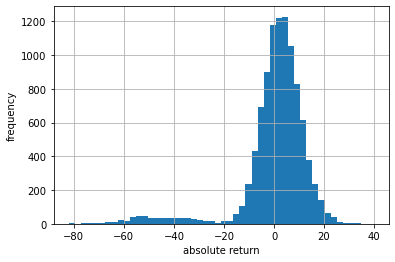

In [9]:
# 이 경우에는 점프 요인이 음수이므로 시뮬레이션 손익은 양봉(bimodal)분포와 유사한 모습을 보인다.
# 정규분포 관점에서 보면 상당한 좌측 팻 테일(fat tail)을 가진다.

plt.hist(R_jd, bins=50)
plt.xlabel('absolute return')
plt.ylabel('frequency')
plt.grid(True)
# tag: var_hist_jd
# title: Absolute returns of jump diffusion (30d)
# size: 60

In [10]:
# 이 시뮬레이션 결과에서 90% 신뢰도를 가진 30일 VaR 값은 이전의 결과와 거의 동일하다.
# 하지만 99% 신뢰도의 VaR값은 기하 브라운 운동 모형의 세 배 이상이다.


percs = [0.01, 0.1, 1., 2.5, 5.0, 10.0]
var = stats.scoreatpercentile(R_jd, percs)
print("%16s %16s" % ('Confidence Level', 'Value-at-Risk'))
print(33 * "-")
for pair in zip(percs, var):
    print("%16.2f %16.3f" % (100 - pair[0], -pair[1]))

Confidence Level    Value-at-Risk
---------------------------------
           99.99           81.112
           99.90           72.570
           99.00           56.133
           97.50           47.149
           95.00           28.400
           90.00            8.788


(-85.6627888431351, 0.0)

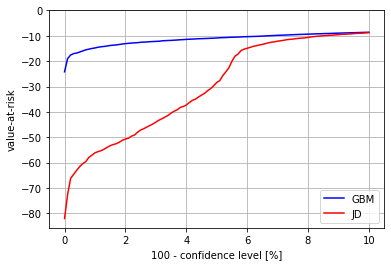

In [11]:
# 이 결과는 표준적인 VaR 측도로 금융 시장에서 종종 발생하는 테일 리스크를 포착하지 못하는 문제를 보여준다.
# 이 점을 더 설명하기 위해 두 경우를 시각적으로 비교하였다.

percs = list(np.arange(0.0, 10.1, 0.1))
gbm_var = stats.scoreatpercentile(R_gbm, percs)
jd_var = stats.scoreatpercentile(R_jd, percs)


plt.plot(percs, gbm_var, 'b', lw=1.5, label='GBM')
plt.plot(percs, jd_var, 'r', lw=1.5, label='JD')
plt.legend(loc=4)
plt.xlabel('100 - confidence level [%]')
plt.ylabel('value-at-risk')
plt.grid(True)
plt.ylim(ymax=0.0)
# tag: var_comp
# title: Value-at-risk for geometric Brownian motion and jump diffusion
# size: 60

In [12]:
# 또 다른 위험 측도는 신용 VaR에서 파생된 CVA (credit value adjustment)이다.
# 신용 VaR는 거래 상대방이 이행의무를 다하지 않을 수 있는 가능성(예를 들면 거래 상대방의 파산 가능성)을 고려한 위험측도이다.
# 파산의 경우 부도 확률(probability of default)과 손실 수준(loss level)의 두 가지 가정이 필요하다.
# 좀 더 구체적으로 다음과 같은 인수를 가지는 블랙-숄즈-머튼 모형을 다시 생각해보자.


S0 = 100.
r = 0.05
sigma = 0.2
T = 1.
I = 100000
ST = S0 * np.exp((r - 0.5 * sigma ** 2) * T 
             + sigma * np.sqrt(T) * np.random.standard_normal(I))

# 가장 단순한 경우로 손실 수준 L과 거래 상대방의 1년 부도 확률 p가 고정되어 있다고 한다.
L = 0.5
p = 0.01

# 부도 시나리오는 포아송 분포를 이용하여 다음과 같이 생성한다. 이때 부도는 한 번만 발생할 수 있다.
D = np.random.poisson(p * T, I)
D = np.where(D > 1, 1, D)

# 부도가 발생하지 않은 경우에는 위험 중립 측도 하에 미래의 주가지수는 해당 자산의 현재 가치와 같아야한다.
# (수치적으로 발생하는 오차는 제외)
print(np.exp(-r * T) * 1 / I * np.sum(ST))

# 이 가정 하에서 신용 VaR은 다음과 같이 계산한다.
CVaR = np.exp(-r * T) * 1 / I * np.sum(L * D * ST)
print(CVaR)

# 같은 방법으로 신용 위험을 조정한 자산의 현재 가치는 다음과 같이 주어진다.

S0_CVA = np.exp(-r * T) * 1 / I * np.sum((1 - L * D) * ST)
print(S0_CVA)

# 이 값은 현재 자산 가치에서 신용 VaR 값을 뺀 것과 거의 같아야 한다.
S0_adj = S0 - CVaR
print(S0_adj)

# 이 시뮬레이션 예에서는 신용 위험에 의한 손실이 약 1,000회 발생하는데 
# 이는 전체 100,000개의 시뮬레이션 경로 중 처음 가정했던 부도확률 1%와 일치한다.

print(np.count_nonzero(L*D*ST))

99.96988113277109
0.5045374970468032
99.46534363572431
99.4954625029532
1014


(0.0, 175.0)

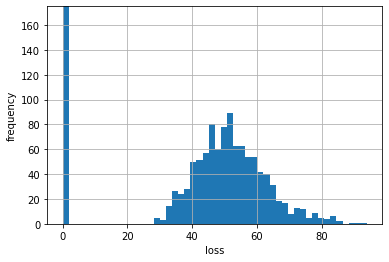

In [13]:
# 부도로 인한 손실의 분포를 보인다. 물론 대부분의 경우에는 부도로 인한 손실이 없다.
# 위험 중립 하에서 부도로 인한 손실 시각화
plt.hist(L * D * ST, bins=50)
plt.xlabel('loss')
plt.ylabel('frequency')
plt.grid(True)
plt.ylim(ymax=175)
# tag: cva_hist_stock
# title: Losses due to risk-neutrally expected default (stock)
# size: 60

In [14]:
# 유러피언 콜 옵션의 가치를 계산하면 행사가가 10인 콜 옵션의 경우 약 10.4이다.
K = 100.
hT = np.maximum(ST - K, 0)
C0 = np.exp(-r * T) * 1 / I * np.sum(hT)
print(C0)

# 같은 가정 하에 모두 확률과 손실 수준을 고려한 신용 VaR 값은 약 5센트이다.
CVaR = np.exp(-r * T) * 1 / I * np.sum(L * D * hT)
print(CVaR)

# 따라서 조정된 옵션 가치는 약 5센트 정도 낮아진다.
C0_CVA = np.exp(-r * T) * 1 / I * np.sum((1 - L * D) * hT)
print(C0_CVA)

# 자산 자체의 경우와 비교하면 옵션 가치 평가는 약간 다른 특성을 보인다.
# 자산의 경우에는 부도로 인한 손실이 1,000회 이상이었는데 옵션의 경우에는 500회 약간 넘을 뿐이다.
# 이는 옵션의 만기 페이오프가 그 자체로 0이 될 확률이 높기 때문이다.

print(np.count_nonzero(L * D * hT))  # number of losses : 손실 횟수
print(np.count_nonzero(D))  # number of defaults : 부도 횟수
print(I - np.count_nonzero(hT))  # zero payoff : 페이오프가 없는 경우



10.418428658874287
0.051760280041137224
10.36666837883315
566
1014
44014


(0.0, 350.0)

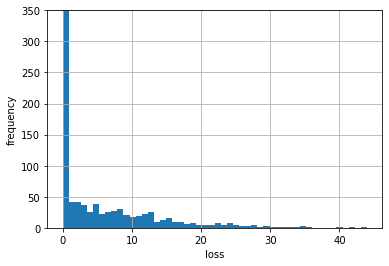

In [15]:
# 옵션에 대한 신용 VaR은 자산 자체의 경우와는 전혀 다른 분포를 보인다.

# 위험 중립 하에서 부도로 인한 손실(콜 옵션의 경우) 시각화
plt.hist(L * D * hT, bins=50)
plt.xlabel('loss')
plt.ylabel('frequency')
plt.grid(True)
plt.ylim(ymax=350)
# tag: cva_hist_opt
# title: Losses due to risk-neutrally expected default (call option)
# size: 60

In [16]:
# 지금까지 금융공학에서 몬테카를로 시뮬레이션을 응용하는 방법을 다루었다.
# 특히 여러 가지 분포에 따른 준-난수를 생성하는 방법을 보였다. 이어서 금융공학 분야에서 중요한 확률 변수와 확률 과정을 시뮬레이션하였다.
# 여기서 자세히 다룬 두 가지는 유러피안 옵션과 아메리칸 옵션의 가치 평가와 VaR, CVA와 같은 위험 측도의 추정 방법이다.

# 몬테카를로 시뮬레이션으로 아메리칸 옵션을 계산하는 것과 같이 계산량이 요구되는 작업에는 numpy를 사용하는 것이 좋다는 것도 보였다.
# 이는 numpy의 함수나 클래스가 C로 구현되어 순수 파이썬 코드보다 속도가 빠르기 때문이다.
# numpy를 사용하는 또 다른 이점은 벡터화 연산에 따른 코드 가독성 및 간결성이다.

In [ ]:
# 금융에서는 이성적 투자자라면 직간접적으로 위험과 수익 간의 트레이드오프를 항상 고려한다.
# 대개 수익률을 계산하는 방법은 아주 명확하지만 위험 측정은 다양한 척도가 존재한다.
# 수익률의 분산과 표준 편차를 이용해 전체 리스크를 산정하기도 하고, 개별 주식이나 포트폴리오 베타를 이용해 시장 리스크를 측정하기도 한다.
# 수익률과 리스크의 비용 균형을 위해 샤프 지수, 트레이너 지수, 소르티노 지수, M2 성과 측정 등의 척도를 이용할 수 있다.
# 이런 척도와 지수에 공통으로 사용하는 형식이 있는데, 
# 리스크 프리미엄으로 표현되는 편익과 표준 편차(혹은 베타 또는 하방 부분 표준 편차)로 표현되는 리스크 사이의 트레이드오프를 표현해 놓은 것
# 한편 척도는 확률 분포를 고려하지 않는다.

# VaR : 신뢰 수준의 확률로 지정한 기간 내 발생 가능한 최대 손실액
# 3가지 명시적 요인 : 미래에 발생 가능한 최대 손실, 지정한 기간, 신뢰 수준 혹은 확률
# 1가지 묵시적 요인 : 현재 포지션 또는 포트폴리오나 개별 주식의 가치

-2.3263478740408408


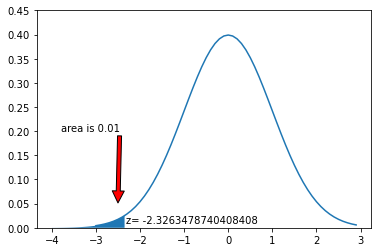

In [18]:
import scipy as sp
from matplotlib import pyplot as plt

# VaR = position * (u_period + z * sigma_p) : z는 양수일
# 신뢰 수준
confidence_level=0.99

# 누적 분포 함수의 역함수 : 결과가 음수가 나옴
z=sp.stats.norm.ppf(1-confidence_level)
print(z)

# z=-2.325       # user can change this number 
xStart=-3.8    # arrow line start x
yStart=0.2     # arrow line start y
xEnd=-2.5      # arrow line end x
yEnd=0.05      # arrow line end y

def f(t):
    return sp.stats.norm.pdf(t) 

plt.ylim(0,0.45)
x = sp.arange(-3,3,0.1) 
y1=f(x)
plt.plot(x,y1)
x2= sp.arange(-4,z,1/40.) 
sum=0
delta=0.05
s=sp.arange(-10,z,delta) 
for i in s:
    sum+=f(i)*delta

plt.annotate('area is '+str(round(sum,4)),xy=(xEnd,yEnd),xytext=(xStart,yStart), arrowprops=dict(facecolor='red',shrink=0.01))
plt.annotate('z= '+str(z),xy=(z,0.01)) 
plt.fill_between(x2,f(x2))
plt.show()

In [52]:
# 주가 데이터를 이용해서 익일 최대 예상 손실을 계산해보자.
# 2017.2.7일 1000 주의 IBM 주식을 보유하고 있다고 가정
# 신뢰 수준 99%로 계산한 다음날 최대 예상 손실액은 얼마인가?
# 일별 수익률의 표준 편차 계산을 위해 최근 5년치 데이터를 이용한다.

import FinanceDataReader as fdr
import numpy as np
import pandas as pd
import scipy as sp


# input area
ticker='IBM'              # input 1
n_shares=1000             # input 2
confidence_level=0.99     # input 3
begdate='2012-02-07'      # input 4
enddate='2017-02-07'      # input 5

df = fdr.DataReader(ticker, begdate, enddate)

z = sp.stats.norm.ppf(1-confidence_level) 

ret = df['Close']/df['Close'].shift(1) - 1
logret = np.log(df['Close']/df['Close'].shift(1))

position=n_shares*df['Close'].iloc[-1]
mean=np.mean(ret)
std=np.std(ret)

# 다음날 VaR
VaR=position*z*std
print("Holding=",position, "VaR=", round(VaR,4), "tomorrow")

# method 1 : 10일 동안의 VaR을 구해보자.
n_days=10
VaR=position*z*std*np.sqrt(n_days)
print("Holding=",position, "VaR=", round(VaR,4), "in 10 Days")

# 10일 평균 수익률을 바로 구하고
# method 2: calculate 10 day returns 
ddate=[]
for i in range(0,np.size(logret)): 
    ddate.append(int(i/n_days))

y=pd.DataFrame(np.array(logret),index=ddate,columns=['Close']) 
retNdays=y.groupby(y.index).sum()

VaR=position*z*np.std(retNdays['Close'])
print("Holding=",position, "VaR=", round(VaR,4), "in ", n_days, "Days")

# method 3: 
ret2=np.sort(retNdays['Close']) 
n=np.size(ret2)
leftTail=int(n*(1-confidence_level))
print(leftTail)
#
VaR3=position*ret2[leftTail]
print("Holding=",position, "VaR=", round(VaR3,0), "in ",n_days, "Days")

# Modified VaR: based on 4 moments
ret=ret.dropna(axis=0)
s=sp.stats.skew(ret)
k=sp.stats.kurtosis(ret)
t=z+1/6.*(z**2-1)*s+1/24.*(z**3-3*z)*k-1/36.*(2*z**3-5*z)*s**2
mVaR=position*(mean-t*std)

print("Holding=",round(position,2), "modified VaR=", round(mVaR,2), "for 1 day ")

Holding= 178460.0 VaR= -4884.2496 tomorrow
Holding= 178460.0 VaR= -15445.3533 in 10 Days
Holding= 178460.0 VaR= -15065.3758 in  10 Days
1
Holding= 178460.0 VaR= -16915.0 in  10 Days
Holding= 178460.0 modified VaR= 8517.75 for 1 day 


In [42]:
# 정규성 검정하기
# shapiro가 노말 분포 검정할 때 가장 엄격하게 한다고 함.
# kstest : 분포 2개를 비교하는 것이므로, 어떤 분포에서도 사용 가능하므로, 노말에서도 사용 가능함.
# anderson : kstest와 같이 어떤 분포라도 비교 가능함. 기존 분포를 알고 있는 경우 ks test보다 더 정교하게 비교가 가능함.
# 비교 가능한 분포로는 {’norm’,’expon’,’logistic’,’gumbel’,’gumbel_l’, gumbel_r’, ‘extreme1’}

print('ticker=',ticker,'W-test, and P-value')
print(sp.stats.shapiro(ret))
print(sp.stats.anderson(ret))


ticker= IBM W-test, and P-value
ShapiroResult(statistic=nan, pvalue=1.0)
AndersonResult(statistic=nan, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


/Users/mac/opt/anaconda3/envs/rl/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  # This is added back by InteractiveShellApp.init_path()
/Users/mac/opt/anaconda3/envs/rl/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  
/Users/mac/opt/anaconda3/envs/rl/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  from ipykernel import kernelapp as app
/Users/mac/opt/anaconda3/envs/rl/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead


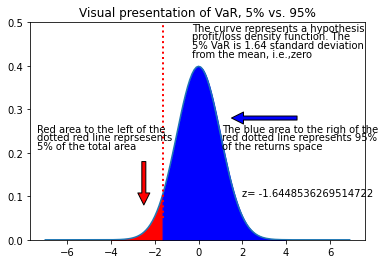

In [53]:
# Visual presentation of VaR
import scipy as sp
from scipy.stats import norm
from matplotlib import pyplot as plt
#
confidence_level=0.95   # input 
z=norm.ppf(1-confidence_level) 
def f(t):
    return sp.stats.norm.pdf(t)
#
plt.ylim(0,0.5)
x = sp.arange(-7,7,0.1) 
ret=f(x)
plt.plot(x,ret)
x2= sp.arange(-4,z,1/40.) 
x3=sp.arange(z,4,1/40.)
sum=0
delta=0.05
s=sp.arange(-3,z,delta) 
for i in s:
    sum+=f(i)*delta
note1='Red area to the left of the'
note2='dotted red line reprsesents'
note3='5% of the total area'
#
note4='The curve represents a hypothesis'
note5='profit/loss density function. The'
note6='5% VaR is 1.64 standard deviation'
note7='from the mean, i.e.,zero'
#
note8='The blue area to the righ of the'
note9='red dotted line represents 95%'
note10='of the returns space'
# this is for the vertical line
plt.axvline(x=z, ymin=0.1, ymax = 1, linewidth=2,ls='dotted', color='r')
plt.figtext(0.14,0.5,note1)
plt.figtext(0.14,0.47,note2)
plt.figtext(0.14,0.44,note3)
#
plt.figtext(0.5,0.85,note4)
plt.figtext(0.5,0.82,note5)
plt.figtext(0.5,0.79,note6)
plt.figtext(0.5,0.76,note7)
plt.annotate("",xy=(-2.5,0.08),xytext=(-2.5,0.18), arrowprops=dict(facecolor='red',shrink=0.001))
#
plt.figtext(0.57,0.5,note8)
plt.figtext(0.57,0.47,note9)
plt.figtext(0.57,0.44,note10)
plt.annotate("",xy=(1.5,0.28),xytext=(4.5,0.28), arrowprops=dict(facecolor='blue',shrink=0.001))
#
plt.annotate('z= '+str(z),xy=(2.,0.1)) 
plt.fill_between(x2,f(x2), color='red')
plt.fill_between(x3,f(x3), color='blue')
plt.title("Visual presentation of VaR, 5% vs. 95%")
plt.show()